Currently pyEclipseDVH creates 2 dataframes, 1 for DVH data and 1 for metrics. 
Implement multiIndex dataframe for each patient of structure:
    
    Patient_ID
    Plan (e.g. AXB)
    Structure
    DVH

Would reference a DVH by PatID['Case1']['AXB']['PTV']

Different structures have different dose indices, with the maximum value given by the maximum real dose. This is also a problem when comparing two algoriths (AAA & AXB) since these have different indices which compicates calculations comparing them. Solution is to put all DVH on a common dose index, 0 - 100 Gy in 0.05 Gy increments, use interpolation to fit raw data to new indices (cant just use reindex as this is limited to forward/backward filling). 

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate
import os

In [2]:
ls

 Volume in drive C is WINDOWS
 Volume Serial Number is AE83-8D62

 Directory of C:\Users\RCole02.ROYALSURREY\Desktop\GitHub\Useful-python-for-medical-physics\Experiments in ipython notebooks\pyEclipseDVH\MultiIndex 2-3-17

02/03/2017  16:43    <DIR>          .
02/03/2017  16:43    <DIR>          ..
02/03/2017  16:34    <DIR>          .ipynb_checkpoints
02/03/2017  16:34    <DIR>          __pycache__
02/03/2017  16:43         1,947,634 All_data.csv
02/03/2017  09:39    <DIR>          archive
01/03/2017  09:21         2,118,998 Case1_AAA.txt
01/03/2017  09:21         2,106,075 Case1_AXB.txt
01/03/2017  09:21         2,635,156 Case5_AAA.txt
01/03/2017  09:21         2,718,192 Case5_AXB.txt
02/03/2017  16:43            61,407 Demo pyEclipseDVH_v2 2-3-2017.ipynb
02/03/2017  16:43           404,269 multiIndex pyEclipseDVH 2-3-2017.ipynb
02/03/2017  16:25             2,690 pyEclipseDVH_v2.py
               8 File(s)     11,994,421 bytes
               5 Dir(s)  364,670,652,416 bytes free


## Create example dataframe with required structure

In [3]:
my_iterables = [['Case1', 'Case5'], ['AXB', 'AAA'], ['PTV CHEST', 'ITV', 'Oesophagus']]

In [4]:
my_index = pd.MultiIndex.from_product(my_iterables, names = ['Patient ID', 'Plan ID', 'Structure'])

In [5]:
my_index

MultiIndex(levels=[['Case1', 'Case5'], ['AAA', 'AXB'], ['ITV', 'Oesophagus', 'PTV CHEST']],
           labels=[[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1], [1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0], [2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1]],
           names=['Patient ID', 'Plan ID', 'Structure'])

In [6]:
df = pd.DataFrame(np.random.randn(12,5), index = my_index)

In [7]:
df = df.T     # for column based indexing

In [8]:
df.index = [0, 0.1, 0.3, 0.5, 5]

In [9]:
df

Patient ID     Case1                                                      \
Plan ID          AXB                            AAA                        
Structure  PTV CHEST       ITV Oesophagus PTV CHEST       ITV Oesophagus   
0.0         1.696082  0.522338   0.669644  0.428085 -2.096154   0.053294   
0.1        -0.267821  0.227608  -0.239473  0.029406 -0.680923  -0.339717   
0.3         1.051074 -0.004546  -0.442744 -0.069017 -1.490755   0.461687   
0.5        -0.748245  0.898976   1.050498 -0.505687 -0.210967   1.379769   
5.0        -0.191100 -1.579262  -1.032550 -0.569692 -0.869115  -0.546807   

Patient ID     Case5                                                      
Plan ID          AXB                            AAA                       
Structure  PTV CHEST       ITV Oesophagus PTV CHEST       ITV Oesophagus  
0.0        -0.484317 -0.034777  -0.014478 -0.028904  1.513963   0.914398  
0.1         0.526383 -3.715558  -0.299387 -2.347971  1.772816   0.547077  
0.3        -0.258584  0.248955   0.255607 -0.115791  1.631766   0.740305  
0.5         0.308643  0.258440  -0.475876 -0.843266 -0.764553   1.572648  
5.0         0.415275 -2.218824  -1.406930 -0.412958  1.454738   1.300085

In [10]:
df['Case1']['AAA']['ITV'].max()

-0.21096659213849875

In [11]:
df.xs('AAA', level='Plan ID', axis=1)

Patient ID     Case1                          Case5                     
Structure  PTV CHEST       ITV Oesophagus PTV CHEST       ITV Oesophagus
0.0         0.428085 -2.096154   0.053294 -0.028904  1.513963   0.914398
0.1         0.029406 -0.680923  -0.339717 -2.347971  1.772816   0.547077
0.3        -0.069017 -1.490755   0.461687 -0.115791  1.631766   0.740305
0.5        -0.505687 -0.210967   1.379769 -0.843266 -0.764553   1.572648
5.0        -0.569692 -0.869115  -0.546807 -0.412958  1.454738   1.300085

In [12]:
df.xs('AAA', level='Plan ID', axis=1).xs('PTV CHEST', level='Structure', axis=1)

Patient ID,Case1,Case5
0.0,0.428085,-0.028904
0.1,0.029406,-2.347971
0.3,-0.069017,-0.115791
0.5,-0.505687,-0.843266
5.0,-0.569692,-0.412958


In [13]:
df.xs('AAA', level='Plan ID', axis=1).xs('PTV CHEST', level='Structure', axis=1).max()

Patient ID
Case1    0.428085
Case5   -0.028904
dtype: float64

In [14]:
df.xs('PTV CHEST', level='Structure', axis=1)

Patient ID     Case1               Case5          
Plan ID          AXB       AAA       AXB       AAA
0.0         1.696082  0.428085 -0.484317 -0.028904
0.1        -0.267821  0.029406  0.526383 -2.347971
0.3         1.051074 -0.069017 -0.258584 -0.115791
0.5        -0.748245 -0.505687  0.308643 -0.843266
5.0        -0.191100 -0.569692  0.415275 -0.412958

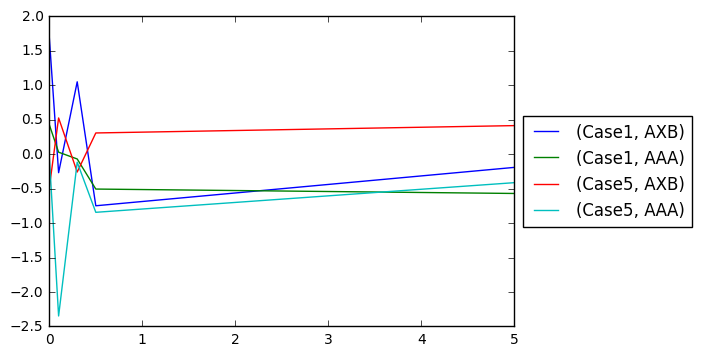

In [15]:
df.xs('PTV CHEST', level='Structure', axis=1).plot().legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Produce function to load files in this format

Dont want a class as producing a dataframe object (could subclass df but this would take more work)

In [16]:
def Load_patient(file):  # file = 'Case1_AAA.txt'  string
    with open(file, "r") as file_:
        my_file = [line for line in file_.readlines()]  # my_file is a list representation of the text file
    file_.close()        
    file_len = len(my_file)                                # number of lines in the file
    patID = my_file[1].split(':')[-1].strip('\n').strip()
    planID = my_file[10].split(':')[-1].strip('\n').strip()
    
        
    ## Get the structures
    structures_indexs_list = []
    structures_names_list  = []
    for i, line in enumerate(my_file):
        if line.startswith('Structure:'):
            structures_indexs_list.append(i)  
            structures_names_list.append(line.split(':')[-1].strip('\n').strip())
    
    
    ##structures_names_list = ['PTV CHEST', 'Foramen'] # hard code to limit number of structures and prevent memory issues
    
    print(file + ' loaded \t patID:' + patID + ' PlanID:' + planID + ' and number of structures is ' + str(len(structures_names_list)))
    dose_index = np.linspace(0,100, 2001)  # New dose index in range 0 - 100 Gy in 0.05 Gy steps
    
    data = np.zeros((dose_index.shape[0], len(structures_names_list)))
    
    # iterate through all structures and place interpolated DVH data in matrix
    for i, index in enumerate(structures_indexs_list):
        start = structures_indexs_list[i]+18  # first line of DVH data
        if i < len(structures_indexs_list)-1:
            end = structures_indexs_list[i+1]-2  # find the last line of the DVH from the next index, BEWARE THE +1
        else:
            end = len(my_file)-2
        DVH_data = my_file[start:end]  # get list with data
            
        DVH_list = [line.split() for line in DVH_data]  # create list of lists split
        Rel_dose_pct, Dose_Gy, Ratio_pct = zip(*DVH_list) # unzip to 3 lists, they are strings so conver to float
        
        Ratio_pct = np.asarray(Ratio_pct, dtype=np.float32)
        Dose_Gy = np.asarray(Dose_Gy, dtype=np.float32)
        ## Now working with dose data
      
        f = interpolate.interp1d(x=Dose_Gy,y=Ratio_pct, bounds_error=False, fill_value=0)   # returns a linear interpolate function, fill values outside range wiwth 0 

        data[:,i] = f(dose_index)
    
    my_iterables = [[patID], ['AAA'], structures_names_list]
    my_index = pd.MultiIndex.from_product(my_iterables, names = ['Patient ID', 'Plan ID', 'Structure'])

    df = pd.DataFrame(data.T, index = my_index)
    df = df.T
    df.index  = dose_index
    df.index.name = 'Dose (Gy)'
    return df

In [17]:
Case1_AAA_df = Load_patient('Case1_AAA.txt')

Case1_AAA.txt loaded 	 patID:Case1 PlanID:AAA and number of structures is 25


In [18]:
Case1_AAA_df.head()

Patient ID       Case1                                                         \
Plan ID            AAA                                                          
Structure         BODY    GTV       Heart     Foramen Foramen+5mm  Oesophagus   
Dose (Gy)                                                                       
0.00        100.000000  100.0  100.000000  100.000000  100.000000  100.000000   
0.05         94.650546  100.0  100.000000  100.000000  100.000000  100.000000   
0.10         84.657252  100.0   99.228210   99.109820   97.594712  100.000000   
0.15         75.699474  100.0   95.117282   89.524147   88.564127   99.694547   
0.20         68.629984  100.0   90.089920   81.775955   81.023144   94.893054   

Patient ID                                                           ...      \
Plan ID                                                              ...       
Structure  Foramen+3mm     Trachea Bronchial tree L Brachial plex    ...       
Dose (Gy)                                                            ...       
0.00        100.000000  100.000000          100.0      100.000000    ...       
0.05        100.000000  100.000000          100.0      100.000000    ...       
0.10         98.241807  100.000000          100.0      100.000000    ...       
0.15         88.683684   92.911855          100.0       99.806907    ...       
0.20         80.788367   77.559046          100.0       70.215692    ...       

Patient ID                                                              \
Plan ID                                                                  
Structure      Rt_Lung Both Lungs-ITV        skin PseudoPTV-ITV    ITV   
Dose (Gy)                                                                
0.00        100.000000     100.000000  100.000000         100.0  100.0   
0.05        100.000000     100.000000   93.089822         100.0  100.0   
0.10        100.000000      99.999345   79.390692         100.0  100.0   
0.15        100.000000      99.402547   67.993675         100.0  100.0   
0.20         99.933248      98.170740   60.040555         100.0  100.0   

Patient ID                                                             
Plan ID                                                                
Structure         ribs Pseudo Ring Pseudo Ribs Dose 100[%] Dose 50[%]  
Dose (Gy)                                                              
0.00        100.000000  100.000000       100.0       100.0      100.0  
0.05        100.000000   97.424545       100.0       100.0      100.0  
0.10        100.000000   97.020139       100.0       100.0      100.0  
0.15        100.000000   96.901027       100.0       100.0      100.0  
0.20         99.940307   96.801463       100.0       100.0      100.0  

[5 rows x 25 columns]

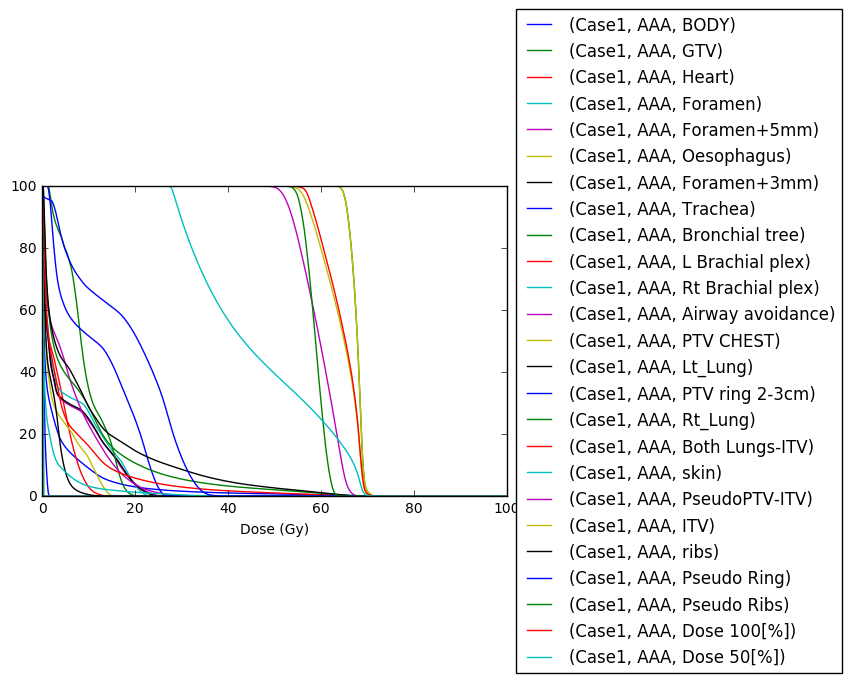

In [19]:
Case1_AAA_df.plot()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

the D50% is Patient ID  Plan ID
Case1       AAA        99.999478
Name: 50.0, dtype: float64


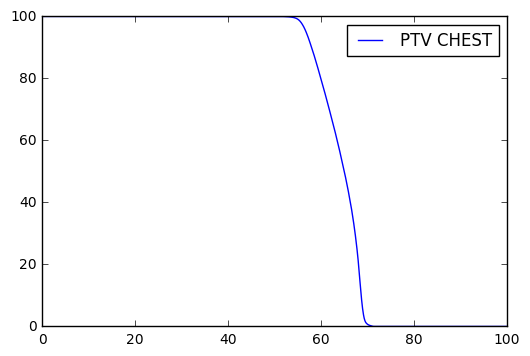

In [20]:
structure = 'PTV CHEST'
data = Case1_AAA_df.xs(structure, level='Structure', axis=1)
print('the D50% is ' + str(data.loc[50]))
plt.plot(data, label = structure)
plt.legend()

In [21]:
data.head()

Patient ID,Case1
Plan ID,AAA
Dose (Gy),
0.00,100.0
0.05,100.0
0.10,100.0
0.15,100.0
0.20,100.0


In [22]:
data.ix[70.0][0]  # get the % at a given Gy

0.66046952917531598

In [23]:
Case1_AAA_df.ix[65.0].max()   # get the % for all structures at a given Gy

96.719696382431721

# Validate against old class

Comparison is good.

In [25]:
#Case1_AAA_class_df = eclipse_DVH('Case1_AAA.txt')

## Load several files and concat

In [26]:
# files = ['Case1_AAA.txt', 'Case1_AXB.txt', 'Case5_AAA.txt', 'Case5_AXB.txt']

In [27]:
files = os.listdir()   # return a list of files
txt_files = [file for file in files if file.endswith('.txt')]

In [28]:
for i, file in enumerate(txt_files):
    if i == 0:
        multi_df = Load_patient(file)        
    else:
        multi_df = pd.concat([multi_df, Load_patient(file)], axis=1)

Case1_AAA.txt loaded 	 patID:Case1 PlanID:AAA and number of structures is 25
Case1_AXB.txt loaded 	 patID:Case1 PlanID:AXB and number of structures is 25
Case5_AAA.txt loaded 	 patID:Case5 PlanID:AAA and number of structures is 29
Case5_AXB.txt loaded 	 patID:Case5 PlanID:AXB and number of structures is 29


In [29]:
multi_df.head()

Patient ID       Case1                                                         \
Plan ID            AAA                                                          
Structure         BODY    GTV       Heart     Foramen Foramen+5mm  Oesophagus   
Dose (Gy)                                                                       
0.00        100.000000  100.0  100.000000  100.000000  100.000000  100.000000   
0.05         94.650546  100.0  100.000000  100.000000  100.000000  100.000000   
0.10         84.657252  100.0   99.228210   99.109820   97.594712  100.000000   
0.15         75.699474  100.0   95.117282   89.524147   88.564127   99.694547   
0.20         68.629984  100.0   90.089920   81.775955   81.023144   94.893054   

Patient ID                                                           ...     \
Plan ID                                                              ...      
Structure  Foramen+3mm     Trachea Bronchial tree L Brachial plex    ...      
Dose (Gy)                                                            ...      
0.00        100.000000  100.000000          100.0      100.000000    ...      
0.05        100.000000  100.000000          100.0      100.000000    ...      
0.10         98.241807  100.000000          100.0      100.000000    ...      
0.15         88.683684   92.911855          100.0       99.806907    ...      
0.20         80.788367   77.559046          100.0       70.215692    ...      

Patient ID           Case5                                                   \
Plan ID                AAA                                                    
Structure  R Brachial plex Pseudo ITV    Ribs-PTV PseudPTV_edit Pseudo ring   
Dose (Gy)                                                                     
0.00                 100.0      100.0  100.000000         100.0  100.000000   
0.05                 100.0      100.0   99.999910         100.0   99.992912   
0.10                 100.0      100.0   99.084434         100.0   99.983445   
0.15                 100.0      100.0   90.151472         100.0   99.970446   
0.20                 100.0      100.0   78.048038         100.0   99.954081   

Patient ID                                                        
Plan ID                                                           
Structure  PseudoPTV_edit   cool Dose 100[%] Dose 27Gy Dose 30Gy  
Dose (Gy)                                                         
0.00                100.0  100.0       100.0     100.0     100.0  
0.05                100.0  100.0       100.0     100.0     100.0  
0.10                100.0  100.0       100.0     100.0     100.0  
0.15                100.0  100.0       100.0     100.0     100.0  
0.20                100.0  100.0       100.0     100.0     100.0  

[5 rows x 108 columns]

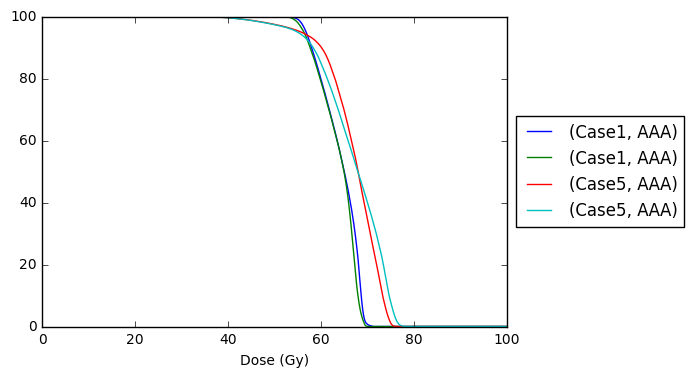

In [30]:
multi_df.xs('PTV CHEST', level='Structure', axis=1).plot()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))